# Un petit réseau à convolution

Trois étapes:
- on prépare les données: sélection de 2 targets, normalisation, formatage
- on créé l'architecture
- on entraîne le réseau: avec l'optimisation de pytorch 

## Préparation des données

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import scale, minmax_scale
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
# Sélection des targets avec pandas
A = pd.DataFrame(X)
A['y'] = y
B = A.loc[A.index[A['y']=='4'].union(A.index[A['y']=='7'])]
# Passage du dataframe pandas vers les tensors de torch 
# + normalisation des images pour que les valeurs des pixels soient entre 0 et 1
# + reshape des données en un tenseur en 4 dimensions : batch, channel, height, width
X_4_7 = torch.tensor(minmax_scale(B.drop("y", axis=1)).astype(np.float32)).reshape(B.shape[0],1,28,28)
y_4_7 = torch.tensor(B.y.replace(['4','7'],[0,1]).values.astype(np.float32)).unsqueeze(-1)

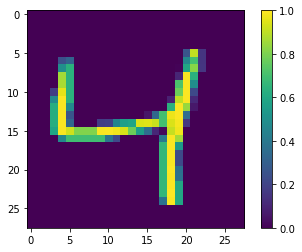

In [2]:
plt.imshow(X_4_7[0][0])
plt.colorbar()

On utilise les wrappers de torch qui facilitent le découpage en minibatch

In [3]:
from torch.utils.data import TensorDataset, DataLoader
mnist_4_7 = TensorDataset(X_4_7, y_4_7) # on lie les entrées aux targets attentues
trainloader = DataLoader(mnist_4_7) # pour faciliter l'échantillonage en mini-batch

In [4]:
trainloader.batch_size

1

## L'architecture
(https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neurl-networks-tutorial-py)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 canal d'entrée, 2 canaux de sortie, convolution par un kernel 5x5
        self.conv1 = nn.Conv2d(1, 2, 5)
        # les parametres du percetron multi-couche: y = Wx + b
        self.fc1 = nn.Linear(2*8*8, 84)  # 8*8 from image dimension
        self.fc2 = nn.Linear(84, 1)

    def forward(self, x):
        # Max pooling sur une fenêtre de 3x3 (par défaut stride=taille de la fenêtre)
        x = F.max_pool2d(F.relu(self.conv1(x)), (3, 3))
        x = torch.flatten(x, start_dim=1) # transforme le tenseur en vecteur (dim 0 est celle du batch)
        # Perceptron
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x)) # P(y|x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=1, bias=True)
)


## L'apprentissage

In [6]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001)

In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5128]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5083]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5239]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5111]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5159]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5317]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5212]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5254]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5260]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5169]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5227]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5153]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5278]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5067]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5183]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5175]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5228]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5140]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5153]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5104]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5120]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5089]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5221]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5109]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5114]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5067]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5157]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5264]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5228]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5234]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5176]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5108]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5119]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5249]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5251]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5175]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5171]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5227]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5231]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5189]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5086]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5188]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5355]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5152]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5191]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5222]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5100]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5219]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5246]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5239]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5087]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5241]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5158]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5269]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5254]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5190]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5174]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5262]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5201]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5109]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5067]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5143]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5048]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5196]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5189]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5145]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4985]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5059]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5058]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5080]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5026]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5072]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5047]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5223]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5095]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5231]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5062]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5203]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5017]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5111]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5089]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5138]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5156]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5205]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5129]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4983]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5192]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5250]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5232]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5076]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5058]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5058]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5236]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5005]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5155]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5129]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5290]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5169]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5211]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5105]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5267]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5069]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5277]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5293]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5257]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5256]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5250]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5124]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5141]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5112]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5107]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5197]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5152]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5157]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5164]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5071]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5157]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5111]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5119]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5097]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5147]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5072]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5086]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5247]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5045]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5177]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5135]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5101]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5108]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5064]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5083]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5210]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5079]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5278]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5246]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5147]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5009]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5222]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5129]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5273]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5127]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5000]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5085]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5110]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5102]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5077]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5233]], grad_fn=<SigmoidBackward>)
i

outputs:  torch.Size([1, 1]) tensor([[0.5244]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5045]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5074]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5262]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5022]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5201]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5143]], grad_fn=<SigmoidBackward>)
i

outputs:  torch.Size([1, 1]) tensor([[0.5143]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5195]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5088]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5055]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5177]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5247]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5191]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5230]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5139]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5246]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5159]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5097]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5109]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5196]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5228]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5126]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5127]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5162]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5192]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5216]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5122]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5237]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5134]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5113]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5135]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5269]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5141]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5267]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5035]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5155]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5244]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5188]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5188]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5083]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5079]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5168]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5020]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5217]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5198]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5163]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5166]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5068]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5059]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5285]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5039]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5249]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5073]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5198]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5276]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5040]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5159]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5286]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5126]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5158]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5254]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5174]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5283]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5168]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5077]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5151]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5206]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5147]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5229]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5260]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5281]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5145]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5084]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5211]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5010]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5081]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5218]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5241]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5236]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5073]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5056]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5090]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5154]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5178]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5265]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5190]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5189]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5192]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5107]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5237]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5217]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5208]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5218]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5099]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5256]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5164]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5143]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5226]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5111]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5075]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5170]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5057]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5112]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5040]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5254]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5007]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5012]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5287]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5267]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5244]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5220]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5018]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5019]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5127]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5004]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5085]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5316]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5355]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5233]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5246]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5247]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5254]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5139]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5274]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5020]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4990]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5066]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5250]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5214]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5164]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5158]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5109]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5258]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5199]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5108]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5229]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5181]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5082]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5113]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5173]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5045]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

outputs:  torch.Size([1, 1]) tensor([[0.5317]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5122]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5161]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5049]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5118]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5193]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5010]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5089]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5220]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5139]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5280]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4955]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5158]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5214]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5262]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5089]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5031]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5203]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5291]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5109]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5256]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5044]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5211]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5059]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5163]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

outputs:  torch.Size([1, 1]) tensor([[0.5088]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5281]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5302]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5139]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5133]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5265]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5176]], grad_fn=<SigmoidBackward>)
i

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5243]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5121]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5254]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5007]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5250]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5088]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5169]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5230]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5146]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5262]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5208]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5194]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5189]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5218]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5144]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5160]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5315]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4958]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5093]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5263]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5017]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5090]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5047]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5136]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5253]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5081]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5051]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5060]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5208]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5277]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5204]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5263]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5009]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5238]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5183]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5243]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5144]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5160]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4970]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5037]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5058]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5155]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5204]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5195]], grad_fn=<SigmoidBackward>)
i

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5252]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5275]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5231]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5187]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5160]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5135]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5049]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4977]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5015]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5062]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5092]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5056]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4995]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5194]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5308]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5291]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4984]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5067]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5281]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5130]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5223]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5100]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5045]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5134]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5181]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5210]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5227]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5236]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5087]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5037]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5035]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5105]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5000]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5177]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5184]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5255]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5131]], grad_fn=<SigmoidBackward>)
i

outputs:  torch.Size([1, 1]) tensor([[0.4967]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4970]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5135]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5219]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5203]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5214]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5178]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5007]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5078]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5057]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5165]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5186]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5165]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5260]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5154]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5165]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5180]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5196]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5248]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5211]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5201]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5222]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5175]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5285]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5204]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5158]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5101]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5101]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5200]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5254]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5259]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4988]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5281]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5270]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4991]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5092]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5035]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5072]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5288]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4907]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5268]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5228]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5157]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5050]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5097]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5288]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5127]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5214]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5245]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5176]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5271]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5221]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5232]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5014]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5129]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5116]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5169]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4997]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5104]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4897]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5159]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5026]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5104]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5193]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5114]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5026]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5074]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5240]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5087]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5297]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5243]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5031]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5182]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4979]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5242]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5296]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5058]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4943]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5244]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5221]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5014]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5094]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5092]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5250]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5080]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5292]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4994]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5277]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5019]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5025]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5079]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4967]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

outputs:  torch.Size([1, 1]) tensor([[0.5271]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5099]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5303]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5155]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5069]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5155]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5105]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4935]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5209]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4922]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5007]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5274]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5262]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4939]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5139]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5116]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5155]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5061]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5126]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5095]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5216]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5227]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5178]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5078]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5289]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5156]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5284]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5114]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5243]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4981]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5046]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5208]], grad_fn=<SigmoidBackward>)
i

outputs:  torch.Size([1, 1]) tensor([[0.5175]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5268]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5260]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5010]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5195]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4938]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5259]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5280]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5069]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5179]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5041]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5203]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5265]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5282]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5206]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5018]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5053]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5014]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5284]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5306]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5137]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5167]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5300]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5120]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5091]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

outputs:  torch.Size([1, 1]) tensor([[0.4916]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5047]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5007]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5183]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5046]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4958]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4927]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5275]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5285]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5107]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5268]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5289]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5092]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5215]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5084]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5203]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5162]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5016]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5296]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5006]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5298]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5185]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5032]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4994]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5000]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5146]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5227]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5103]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4997]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4914]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5062]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4939]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5095]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5068]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5176]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4950]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5086]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5089]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5276]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5211]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5103]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4971]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5020]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5025]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4933]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5082]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5229]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5240]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5125]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5202]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5104]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4943]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5161]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5114]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5097]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5067]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5242]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5223]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5071]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5233]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5220]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5110]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5284]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4956]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5295]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5072]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5012]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5173]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5023]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5132]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5091]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4996]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5255]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5291]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5026]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5084]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5295]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5293]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5067]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5100]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5256]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5173]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5278]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5147]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5169]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

outputs:  torch.Size([1, 1]) tensor([[0.5028]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5337]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5292]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5141]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5218]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5117]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5150]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5096]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5331]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5345]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5176]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4906]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5231]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5198]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4998]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5181]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5217]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4883]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5045]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5209]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5252]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5059]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4900]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5115]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5225]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5113]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5037]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5161]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4973]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4852]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5258]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5121]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5034]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4960]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5033]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5099]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5183]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5219]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5255]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5054]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5223]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4978]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5264]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5140]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5135]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5163]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5168]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4985]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5008]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5189]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5249]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5099]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5273]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5091]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5236]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5254]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5005]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5192]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5267]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5242]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5186]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5255]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

outputs:  torch.Size([1, 1]) tensor([[0.5254]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5102]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4995]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5163]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5146]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5168]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5342]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5137]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5020]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5165]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5062]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5150]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5257]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5168]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5125]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5184]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5019]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5003]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5274]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5114]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5178]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5004]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5320]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4955]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5362]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5365]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5328]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5185]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5006]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5104]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4925]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5273]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5272]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5133]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5097]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5102]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5168]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4925]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4996]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5263]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5270]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5090]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5036]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5175]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4908]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5234]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5299]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5310]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5187]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5237]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5101]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5221]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5161]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4933]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5236]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5000]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5197]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4936]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4975]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5181]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5153]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5130]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5119]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4966]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5189]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5201]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5150]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5260]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5276]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5064]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5137]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5031]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5141]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5301]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5326]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5009]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5010]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5265]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5153]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5035]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5330]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5335]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5196]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5073]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5299]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4999]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4955]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5039]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5187]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5024]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5306]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5092]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5154]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5035]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5116]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5130]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5310]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4974]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5242]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4905]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4982]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5063]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5306]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5302]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4959]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5283]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5347]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4944]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4946]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5098]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5213]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4936]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5008]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5206]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5019]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5061]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5294]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4979]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5103]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4892]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5039]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5234]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5186]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4938]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5234]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5290]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4975]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5261]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4916]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5328]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4871]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5037]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4994]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5119]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

outputs:  torch.Size([1, 1]) tensor([[0.5272]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5218]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4979]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5153]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4999]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5213]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5071]], grad_fn=<SigmoidBackward>)
i

outputs:  torch.Size([1, 1]) tensor([[0.5234]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4978]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5158]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5108]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4966]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5150]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4918]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5083]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5007]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5389]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5160]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4935]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5134]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5135]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5241]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5049]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5142]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5084]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5279]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4974]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5292]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5013]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4921]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5105]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4904]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5271]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5004]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5263]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5228]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5147]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4943]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5129]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5097]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5215]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5086]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5277]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4993]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5200]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5078]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5349]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5128]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5377]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5353]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4954]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5040]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5284]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5138]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4986]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5174]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5290]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5104]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5299]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5311]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5299]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4852]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5166]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5348]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5264]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5043]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5226]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5005]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5218]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4942]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5304]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4862]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4881]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4964]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4927]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5075]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5206]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5168]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5237]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5084]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4901]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

outputs:  torch.Size([1, 1]) tensor([[0.5008]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4863]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4882]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5314]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5359]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5249]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5039]], grad_fn=<SigmoidBackward>)
i

labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5055]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5065]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5027]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4792]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5319]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5221]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

outputs:  torch.Size([1, 1]) tensor([[0.5210]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5298]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4892]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5146]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5186]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5015]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5333]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5240]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5153]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4970]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4829]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5146]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5258]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

outputs:  torch.Size([1, 1]) tensor([[0.5143]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4989]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5118]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5216]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5074]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5119]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4900]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5311]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5250]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5255]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5282]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5348]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5173]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5166]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4879]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5150]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4947]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5279]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5292]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5112]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5241]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5138]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4973]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4964]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4919]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5081]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4969]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5252]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5093]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5307]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5250]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4996]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5078]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5118]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4893]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5170]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4946]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4930]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4853]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5289]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4942]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5134]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4899]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5297]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5315]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5118]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5336]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5090]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5278]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5198]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5053]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5186]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5322]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5251]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5286]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4969]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5329]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5037]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5054]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5307]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5326]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4963]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5242]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5218]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5262]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5328]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4923]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5409]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5195]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5231]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5342]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5069]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4726]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5379]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5039]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5292]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5191]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5059]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5281]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5138]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5246]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5178]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5162]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4840]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5119]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5306]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5142]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5054]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5045]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5299]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5166]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5062]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5059]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4993]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5112]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5275]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5038]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4990]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5350]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4977]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5253]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5262]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5114]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5050]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5223]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4973]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4884]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5035]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5148]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5201]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5243]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5081]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5229]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5133]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5203]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5195]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5263]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5374]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4861]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5080]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5086]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4991]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4945]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4882]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5030]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4842]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5271]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5270]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4961]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5359]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5005]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5299]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5242]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5362]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4974]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5327]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5161]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4959]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5074]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4874]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5006]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5099]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5061]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4810]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5363]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5024]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5325]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5350]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5403]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4934]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4945]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5105]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5104]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5129]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5134]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5071]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5120]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5416]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5432]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5010]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5032]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4979]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5288]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4949]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5221]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5193]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4976]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4934]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4995]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5262]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5195]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4944]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5049]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5299]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5121]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5311]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5203]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5149]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4805]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5270]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4886]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5080]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5332]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4852]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4883]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5343]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5259]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5405]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.4990]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5413]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4955]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5331]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4907]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5354]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5340]], grad_fn=<SigmoidBackward>)
i

labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4862]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5307]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5247]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5262]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5000]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5197]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5273]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4848]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5366]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4805]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5291]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4951]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5021]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5250]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5198]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5224]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5191]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5054]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5301]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5175]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5210]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5380]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5017]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5208]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4888]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5417]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5445]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5395]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5201]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5420]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5375]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4712]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4930]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5170]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5357]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5411]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4893]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5321]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4875]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5273]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5345]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4924]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5364]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4967]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5182]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5053]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5314]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4946]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5428]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4778]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4935]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4984]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4810]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4993]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4977]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5280]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5114]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5315]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5388]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5069]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5009]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5340]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5063]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5047]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5014]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5314]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5145]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4979]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5174]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4940]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5196]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4756]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4761]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4983]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5337]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5029]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5217]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5048]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5238]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5329]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4954]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4916]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5402]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4916]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5232]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4763]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5186]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5433]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4929]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5105]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5348]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5136]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5080]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5382]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5322]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4968]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5375]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4932]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5356]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4970]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4994]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5049]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5108]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4930]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5220]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5269]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5138]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5363]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5294]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5446]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4846]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4908]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5336]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5441]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5136]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4989]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5190]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5221]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5072]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5096]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4925]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4944]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5439]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5095]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5250]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4931]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5302]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4888]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5406]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5246]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4732]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5239]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4995]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4923]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4854]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5039]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5436]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5471]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5350]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4854]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4992]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5230]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5151]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5131]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5192]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4883]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5030]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5111]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5126]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4923]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

outputs:  torch.Size([1, 1]) tensor([[0.5260]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5366]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5318]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4881]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4946]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4793]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4898]], grad_fn=<SigmoidBackward>)
i

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5322]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5412]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5432]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5068]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5217]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4996]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4937]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5179]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5164]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5111]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4996]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4854]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

outputs:  torch.Size([1, 1]) tensor([[0.5041]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4975]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5321]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5360]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5323]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5310]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5277]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4930]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5379]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4779]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5480]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4891]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4915]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5051]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5380]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4844]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4983]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5104]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5372]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5176]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4855]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5100]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5308]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4945]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5205]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4986]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5101]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4986]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5037]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4863]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5092]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5125]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5176]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5334]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5040]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5400]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4807]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5160]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4825]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4814]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5459]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5333]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5510]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4804]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5212]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5109]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5113]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4900]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5261]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5012]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4908]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5119]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4787]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5301]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5080]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4978]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4841]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4996]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4972]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5356]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5229]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5327]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5174]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4831]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4698]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5070]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5186]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5195]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4857]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5404]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4939]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5194]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5392]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5311]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4759]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5409]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5095]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5396]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4943]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5185]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5362]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4755]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5294]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5186]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4896]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5308]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5291]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5379]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5377]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5120]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5340]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4987]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5400]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4652]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5048]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5445]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5227]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4832]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5228]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5368]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4892]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4955]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5031]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5341]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5382]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5063]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5227]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5131]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5124]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4760]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5404]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5041]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5372]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5284]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5402]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5032]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5119]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5531]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4821]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4898]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4917]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5399]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5486]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4982]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

outputs:  torch.Size([1, 1]) tensor([[0.4725]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4880]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5025]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5303]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4826]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5493]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5437]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5158]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5402]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5163]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5339]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5330]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5091]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5090]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5013]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4820]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5072]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4952]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5255]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4784]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4988]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5272]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5097]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4922]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4822]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4664]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4982]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4916]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5456]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4730]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5146]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4744]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5116]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4675]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4841]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4971]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5299]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.4838]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4823]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5265]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4985]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4930]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5247]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4943]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5362]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5484]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5327]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4950]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5276]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4745]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

outputs:  torch.Size([1, 1]) tensor([[0.5024]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5279]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5208]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5219]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4907]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5044]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5262]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5244]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5139]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5329]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5310]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5303]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5349]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5353]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5447]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5020]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5468]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5022]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5151]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4772]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4583]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5007]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5336]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4727]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5294]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5389]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5065]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4794]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5059]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5345]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4686]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

outputs:  torch.Size([1, 1]) tensor([[0.4870]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5325]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5299]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5156]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5405]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5160]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5096]], grad_fn=<SigmoidBackward>)
i

labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4896]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5414]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4860]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5130]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5444]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4829]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5535]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4677]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4923]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4821]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5465]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4730]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

outputs:  torch.Size([1, 1]) tensor([[0.5353]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5340]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5416]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4850]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4853]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5032]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4773]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5283]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4868]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5559]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4905]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5130]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4975]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5146]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4812]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5259]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5470]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4730]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4670]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4743]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5192]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5199]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5366]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5293]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4579]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5385]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4940]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4995]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5526]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4694]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5331]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5437]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4705]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5460]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4807]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4607]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5360]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5438]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4635]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5446]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4932]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4877]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5453]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4619]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4463]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5101]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4921]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5010]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4685]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5171]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5459]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5427]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5244]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5366]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4729]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4972]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.4664]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4975]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5189]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5114]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5054]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5460]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4854]], grad_fn=<SigmoidBackward>)
i

outputs:  torch.Size([1, 1]) tensor([[0.5003]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4479]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5032]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4807]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5123]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4719]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5316]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4995]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5368]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4960]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5281]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5044]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4634]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

outputs:  torch.Size([1, 1]) tensor([[0.5547]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5124]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4720]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5200]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5371]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5370]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5168]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4879]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4927]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5481]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4851]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5526]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4876]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5186]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4996]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4943]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4648]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5122]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4753]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5199]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4893]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4564]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5151]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5058]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4746]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4688]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5058]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4772]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4721]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5211]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4936]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4833]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4819]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5407]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5379]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5478]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5481]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4668]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5196]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5428]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4546]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5441]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5180]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

outputs:  torch.Size([1, 1]) tensor([[0.5297]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5363]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4863]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4773]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4744]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5316]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4759]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5094]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5460]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5206]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4660]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4646]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4858]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5480]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5221]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5454]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5295]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4736]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4817]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5268]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5296]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5396]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4696]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5598]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5215]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4585]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5510]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5523]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5366]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4666]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5413]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4696]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5569]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5236]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4686]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4522]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4651]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5272]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5034]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5182]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4883]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5314]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5463]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4604]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4676]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5426]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4680]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4578]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5289]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5548]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5163]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5246]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4856]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5062]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5423]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4876]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4536]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4592]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5281]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5365]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5386]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5309]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5486]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4658]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4815]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4637]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5192]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

outputs:  torch.Size([1, 1]) tensor([[0.4516]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4636]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5418]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4767]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5256]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5445]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5429]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4646]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5095]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4829]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5208]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5165]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4961]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5168]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5214]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4576]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5024]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4577]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4851]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5219]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5587]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5079]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4796]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5462]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5416]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5047]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4856]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4531]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5189]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4628]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4412]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5582]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4730]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5398]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5403]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4702]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5238]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5018]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4487]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5577]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4932]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4544]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5529]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5676]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5038]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5099]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4852]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4729]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4897]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5052]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4816]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5302]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5155]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4730]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4992]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4950]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4570]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4715]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5480]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4940]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4733]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4551]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5179]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5107]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4803]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4751]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5677]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5137]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4754]], grad_fn=<SigmoidBackward>)
i

labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4508]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4536]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5130]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5343]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4922]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5307]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5623]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5358]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4836]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4948]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5699]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4894]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5486]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5084]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5474]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5542]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5418]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4602]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4408]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4661]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5503]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4808]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5473]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4941]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5400]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5396]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5356]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5389]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5463]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4579]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5544]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5461]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4622]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5182]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5315]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4798]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4591]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

outputs:  torch.Size([1, 1]) tensor([[0.5342]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4628]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5407]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4760]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5339]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5411]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5366]], grad_fn=<SigmoidBackward>)
i

labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4923]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4557]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5523]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4385]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5351]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5275]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5355]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5186]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4570]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5257]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4772]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5067]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5295]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4452]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5427]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5060]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5267]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5629]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5267]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4945]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4529]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4715]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5309]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5005]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

outputs:  torch.Size([1, 1]) tensor([[0.4910]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5072]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4883]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5372]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5330]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5330]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4900]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4765]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5419]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5425]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5394]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5439]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4656]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

outputs:  torch.Size([1, 1]) tensor([[0.5275]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4701]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4869]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5450]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5563]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5061]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4604]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4756]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5456]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4868]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4771]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4503]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5314]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5239]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5160]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5563]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4632]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4464]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5315]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5339]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4718]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4881]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4899]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5699]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4639]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5144]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5449]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4659]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5454]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4704]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5148]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

outputs:  torch.Size([1, 1]) tensor([[0.5279]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4907]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5609]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5288]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5281]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4889]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4738]], grad_fn=<SigmoidBackward>)
i

outputs:  torch.Size([1, 1]) tensor([[0.5420]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4955]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5420]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4598]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5588]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4799]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4598]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5161]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4983]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5359]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5207]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5560]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5552]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4728]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5057]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4568]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4650]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4626]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5336]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5491]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5003]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5570]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4568]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5525]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4400]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4574]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4902]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4845]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5579]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4859]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5241]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5435]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4455]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4530]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4849]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5595]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5624]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5127]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5513]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4771]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4310]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5666]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5784]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4935]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4619]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5134]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4511]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4691]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5522]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4930]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5328]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5234]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4806]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5338]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5368]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5305]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5483]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4661]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5049]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4836]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5046]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4455]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4370]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5510]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5444]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4512]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4933]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4715]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4697]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5622]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5460]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4651]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5502]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5658]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4640]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4409]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5177]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4625]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5461]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4978]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4736]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4179]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5495]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5328]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4516]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4284]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4839]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5005]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4579]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5338]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5191]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5572]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5123]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4900]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4908]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5425]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5109]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4803]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5105]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5584]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5559]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5272]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4737]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5204]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5349]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5235]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5512]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5356]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5215]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4601]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4403]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4729]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5483]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4461]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4779]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4738]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5049]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4800]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5783]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4846]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5593]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4540]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5484]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5010]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4897]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5370]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5040]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4871]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4983]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5416]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4556]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5539]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4180]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4483]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4798]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5319]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4102]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5500]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5418]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4528]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.5590]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4863]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4569]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4707]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5813]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4420]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5842]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5725]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4635]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5316]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5283]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5667]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5379]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5290]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5491]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5464]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4274]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5130]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5009]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

outputs:  torch.Size([1, 1]) tensor([[0.4992]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4379]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4250]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5650]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5722]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4695]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4623]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4624]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4193]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5604]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5239]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4162]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5588]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4427]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5432]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5327]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5212]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4506]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5551]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4698]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4482]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5648]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5714]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4479]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5599]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5074]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4622]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4868]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4696]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4782]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5572]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5217]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5048]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5130]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5841]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4453]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5211]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4476]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5716]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4378]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5676]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4438]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4498]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4560]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5832]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5876]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5924]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5901]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4456]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5400]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4493]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4443]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4382]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5376]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5596]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4307]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5183]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4422]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5068]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4488]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5380]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

outputs:  torch.Size([1, 1]) tensor([[0.5388]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4756]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5016]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5656]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5386]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5760]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4584]], grad_fn=<SigmoidBackward>)
i

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4803]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5639]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5222]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5696]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4324]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5011]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5567]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4778]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4171]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5457]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4247]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4507]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4876]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5161]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4374]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5406]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4282]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5856]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5512]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4369]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5192]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5140]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4992]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4605]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5584]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5142]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4675]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4031]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5450]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4914]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4822]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5527]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4740]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4982]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5358]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4599]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5559]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5706]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5866]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5579]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4563]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5629]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4153]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4567]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5729]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4275]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5642]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5577]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4948]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.5199]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5361]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4399]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5488]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5557]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5661]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4576]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4970]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4709]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4867]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5722]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4949]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4254]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5284]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4562]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4647]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4102]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5937]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5369]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4993]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5346]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4414]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5790]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5645]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5516]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4945]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4148]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4430]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4915]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.6012]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4438]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4429]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4502]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4028]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4345]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4540]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5671]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4275]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4342]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5763]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4253]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4489]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4186]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5612]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5687]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4547]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5801]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4803]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4228]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5057]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4795]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4882]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4085]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]

outputs:  torch.Size([1, 1]) tensor([[0.4112]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5387]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4392]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4472]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5345]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5162]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5727]], grad_fn=<SigmoidBackward>)
i

labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4235]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5665]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5229]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5590]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4971]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4891]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4227]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5976]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4696]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5622]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.3975]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5595]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4301]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4547]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4471]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4217]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5604]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5350]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5697]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4423]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4420]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5715]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4400]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5977]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4473]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5718]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4134]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5848]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4349]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5289]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5886]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5888]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.3993]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5927]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5742]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4288]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5501]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4626]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4607]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5345]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5013]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4334]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tens

inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5270]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4612]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.4864]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4506]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]])
outputs:  torch.Size([1, 1]) tensor([[0.5632]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[0.]])
outputs:  torch.Size([1, 1]) tensor([[0.4413]], grad_fn=<SigmoidBackward>)
inputs:  torch.Size([1, 1, 28, 28])
labels:  torch.Size([1, 1]) tensor([[1.]